In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torchvision.transforms import Compose, Grayscale, Resize, ToTensor, Normalize
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_height, input_width):
        super(ImprovedAutoencoder, self).__init__()

        # Определяем размер после свёрточных слоёв
        def conv_output_size(size, kernel_size=3, stride=2, padding=1):
            return (size - kernel_size + 2 * padding) // stride + 1

        h, w = input_height, input_width
        h, w = conv_output_size(h), conv_output_size(w)  # 1-й слой
        h, w = conv_output_size(h), conv_output_size(w)  # 2-й слой
        h, w = conv_output_size(h), conv_output_size(w)  # 3-й слой

        self.flattened_size = h * w * 128  # Выход из Encoder

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, self.flattened_size),
            nn.Unflatten(1, (128, h, w)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Преобразуем в черно-белое изображение
        if self.transform:
            image = self.transform(image)
        return image

In [6]:
batch_size = 32
learning_rate = 0.000252
num_epochs = 10
image_size = (128, 128)  # Размер входного изображения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TensorBoard writer
writer = SummaryWriter(log_dir="logs/final_autoencoder")

# Загрузка данных
data_dir = 'dataset/train'
transform = Compose([
    Grayscale(num_output_channels=1),
    Resize(image_size),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])
dataset = CustomDataset(data_dir, transform)

In [7]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Модель, оптимизатор, функция потерь
model = ImprovedAutoencoder(input_height=image_size[0], input_width=image_size[1]).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/home/sus/Documents/ai_hub_itmo_image_hw1/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    writer.add_scalar("Loss/Train", train_loss, epoch)

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    scheduler.step(val_loss)

    # Сохранение лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "models/best_autoencoder.pth")

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

writer.close()

Epoch 1/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 829.16it/s]


Epoch 1/10 - Train Loss: 0.044830, Val Loss: 0.018551


Epoch 2/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 863.58it/s]


Epoch 2/10 - Train Loss: 0.013132, Val Loss: 0.010988


Epoch 3/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 886.58it/s]


Epoch 3/10 - Train Loss: 0.009635, Val Loss: 0.009079


Epoch 4/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 923.97it/s]


Epoch 4/10 - Train Loss: 0.008467, Val Loss: 0.008179


Epoch 5/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 767.86it/s]


Epoch 5/10 - Train Loss: 0.007922, Val Loss: 0.007836


Epoch 6/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 919.72it/s]


Epoch 6/10 - Train Loss: 0.007626, Val Loss: 0.007461


Epoch 7/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 884.84it/s]


Epoch 7/10 - Train Loss: 0.007429, Val Loss: 0.007256


Epoch 8/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 859.73it/s]


Epoch 8/10 - Train Loss: 0.007296, Val Loss: 0.007165


Epoch 9/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 903.79it/s]


Epoch 9/10 - Train Loss: 0.007201, Val Loss: 0.007067


Epoch 10/10 - Validation: 100%|██████████| 1000/1000 [00:01<00:00, 910.24it/s]


Epoch 10/10 - Train Loss: 0.007131, Val Loss: 0.007027


In [9]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

def eval_model(model, loader):
    model.eval()
    losses = []
    criterion = nn.MSELoss()

    with torch.no_grad():
        for inputs in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs).item()
            losses.append(loss)

    return np.array(losses)

def compute_metrics(y_true, losses, threshold):
    predictions = (losses >= threshold).astype(int)
    tpr = np.sum((predictions == 1) & (y_true == 1)) / np.sum(y_true == 1)
    tnr = np.sum((predictions == 0) & (y_true == 0)) / np.sum(y_true == 0)
    roc_auc = auc(*roc_curve(y_true, losses)[:2])
    return tpr, tnr, roc_auc

def det_threshold(model, val_loader, proliv_loader, plot=True):
    model.to(device)

    val_losses = eval_model(model, val_loader)
    proliv_losses = eval_model(model, proliv_loader)

    y_true = np.hstack((np.zeros(len(val_losses)), np.ones(len(proliv_losses))))
    losses = np.hstack((val_losses, proliv_losses))

    fpr, tpr, thresholds = roc_curve(y_true, losses)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    if plot:
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.title("ROC Curve")
        plt.show()

    tpr, tnr, roc_auc = compute_metrics(y_true, losses, optimal_threshold)
    return optimal_threshold, tpr, tnr, roc_auc

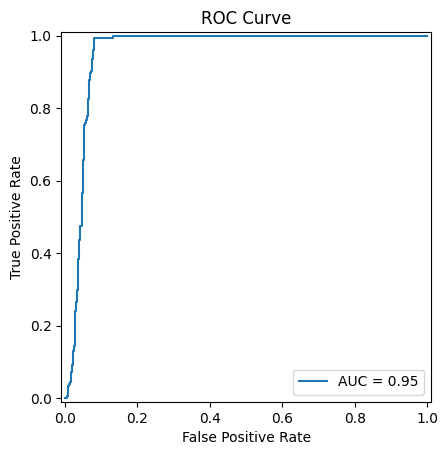

Optimal Threshold: 0.01411605253815651
True Positive Rate (TPR): 99.35%
True Negative Rate (TNR): 91.90%
ROC-AUC: 0.95


In [10]:
proliv_dir = 'dataset/proliv'

proliv_dataset = CustomDataset(proliv_dir, transform)
proliv_loader = DataLoader(proliv_dataset, batch_size=1, shuffle=False)

optimal_threshold, tpr, tnr, roc_auc = det_threshold(model, val_loader, proliv_loader, plot=True)
print(f"Optimal Threshold: {optimal_threshold}")
print(f"True Positive Rate (TPR): {tpr:.2%}")
print(f"True Negative Rate (TNR): {tnr:.2%}")
print(f"ROC-AUC: {roc_auc:.2f}")

In [15]:
def classify_images(model, dataloader, device, threshold):
    model.eval()
    predictions = []
    criterion = nn.MSELoss()

    with torch.no_grad():
        for inputs in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            mse = criterion(outputs, inputs).item()

            predictions.append(1 if mse >= threshold else 0)  # 1 — proliv, 0 — не_пролив
    return predictions

In [16]:
def evaluate_model(predictions, annotations_path):
    true_labels = []
    with open(annotations_path, 'r') as f:
        for line in f:
            _, label = line.strip().split()
            true_labels.append(int(label))

    true_positive = sum((p == 1 and t == 1) for p, t in zip(predictions, true_labels))
    true_negative = sum((p == 0 and t == 0) for p, t in zip(predictions, true_labels))
    false_positive = sum((p == 1 and t == 0) for p, t in zip(predictions, true_labels))
    false_negative = sum((p == 0 and t == 1) for p, t in zip(predictions, true_labels))

    tpr = true_positive / (true_positive + false_negative)
    tnr = true_negative / (true_negative + false_positive)

    return tpr, tnr

In [17]:
test_dir = 'dataset/test/imgs'
annotations_path = 'dataset/test/test_annotation.txt'

test_dataset = CustomDataset(test_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
predictions = classify_images(model, test_loader, device, optimal_threshold)

tpr, tnr = evaluate_model(predictions, annotations_path)
print(f"True Positive Rate (TPR): {tpr:.2%}")
print(f"True Negative Rate (TNR): {tnr:.2%}")


100%|██████████| 3794/3794 [00:04<00:00, 826.93it/s]

True Positive Rate (TPR): 31.78%
True Negative Rate (TNR): 69.77%
